
## MetObs API key (keep private)
2a0bf9fc-ab9c-4616-bb48-21ca990be16f



# Assignment roadmap
- Scope: compare forecast models vs measured GHI for station 06072; compute RMSE & bias per horizon; produce plots and poster-ready figures.
- Data cadence: forecasts hourly/right-binned; measurements 10 min/right-labeled -> resample to hourly.
- Keys: keep everything in UTC; align on forecast issue time + horizon.



## 1) Measurement data (DMI MetObs)
- Download 10-min GHI for station 06072 via API key; basic QC (BSRN min/max).
- Resample to 1h mean (`df.resample('1H', label='right', closed='right').mean()`).
- Save cleaned hourly series for reuse.



### Load hourly measurements
Load resampled station observations (`station_data_hourly.csv`).


In [15]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

obs_path = Path('station_data_hourly.csv')
obs_hourly = pd.read_csv(obs_path, parse_dates=['time'])

print(f'Loaded {len(obs_hourly)} hourly rows from {obs_path}')
display(obs_hourly.head())


Loaded 408 hourly rows from station_data_hourly.csv


,time,ghi
0,2025-11-08 01:00:00+00:00,0.0
1,2025-11-08 02:00:00+00:00,0.0
2,2025-11-08 03:00:00+00:00,0.0
3,2025-11-08 04:00:00+00:00,0.0
4,2025-11-08 05:00:00+00:00,0.0



## 2) Forecast data (open-meteo files)
- Load all `06072_YYYYMMDDT0600.csv` files; parse `date` as datetime (UTC).
- Long-form melt for stacking models; track forecast issue time for horizons.
- Note model horizons differ (e.g., Harmonie ~54h, ECMWF IFS ~10d).



### Setup
Imports and common paths.


In [16]:
data_dir = Path("ForcastData")
files = sorted(data_dir.glob("06072_*.csv"))
print(f"Found {len(files)} forecast files in {data_dir}")


Found 11 forecast files in ForcastData



### Load all forecasts and reshape
- Load every `06072_YYYYMMDDT0600.csv` in `ForcastData`.
- Add `issue_time` from filename; compute `horizon_hours = date - issue_time`.
- Melt wide model columns into long `model`/`forecast` for easier grouping and metrics.


In [17]:

from typing import List


def issue_from_name(path: Path) -> pd.Timestamp:
    ts = path.stem.split('_')[1]  # e.g., 20251108T0600
    return pd.to_datetime(ts, format="%Y%m%dT%H%M", utc=True)

frames: List[pd.DataFrame] = []
for f in files:
    issue_time = issue_from_name(f)
    df_tmp = pd.read_csv(f, parse_dates=["date"])
    df_tmp["issue_time"] = issue_time
    df_tmp["horizon_hours"] = (df_tmp["date"] - df_tmp["issue_time"]).dt.total_seconds() / 3600
    long_tmp = df_tmp.melt(
        id_vars=["date", "issue_time", "horizon_hours"],
        var_name="model",
        value_name="forecast"
    )
    long_tmp["source_file"] = f.name
    frames.append(long_tmp)

all_forecasts = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(all_forecasts))
display(all_forecasts.head())

# Quick check: max horizon per model to understand coverage
max_h = all_forecasts.groupby("model")["horizon_hours"].max().sort_values()
print("\nMax horizon (hours) per model:\n", max_h)


Loaded rows: 14784


,date,issue_time,horizon_hours,model,forecast,source_file
0,2025-11-08 00:00:00+00:00,2025-11-08 06:00:00+00:00,-6.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
1,2025-11-08 01:00:00+00:00,2025-11-08 06:00:00+00:00,-5.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
2,2025-11-08 02:00:00+00:00,2025-11-08 06:00:00+00:00,-4.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
3,2025-11-08 03:00:00+00:00,2025-11-08 06:00:00+00:00,-3.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
4,2025-11-08 04:00:00+00:00,2025-11-08 06:00:00+00:00,-2.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv



Max horizon (hours) per model:
 model
dmi_harmonie_arome_europe    161.0
dmi_seamless                 161.0
ecmwf_aifs025_single         161.0
ecmwf_ifs                    161.0
ecmwf_ifs025                 161.0
gfs_global                   161.0
gfs_seamless                 161.0
metno_nordic                 161.0
Name: horizon_hours, dtype: float64



### Quick single-file preview & plot
Plot one forecast file to see model shapes.


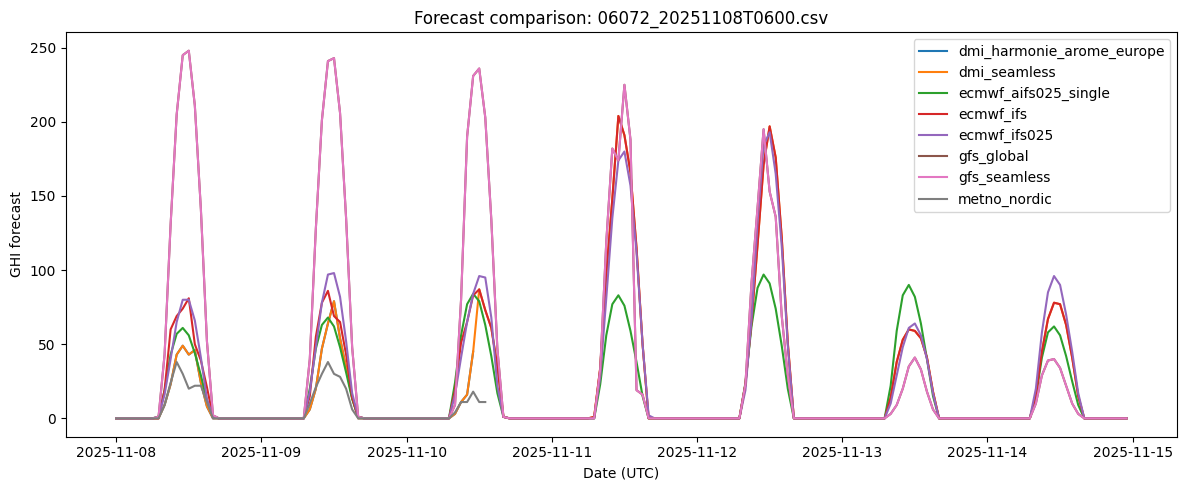

In [18]:

if not files:
    raise ValueError("No forecast files found")

first_file = files[0] # write 0-10 to plot the diffrent files
df_single = pd.read_csv(first_file, parse_dates=["date"])
long_single = df_single.melt(id_vars="date", var_name="model", value_name="forecast")

plt.figure(figsize=(12, 5))
for model, grp in long_single.groupby("model"):
    plt.plot(grp["date"], grp["forecast"], label=model, linewidth=1.5)

plt.xlabel("Date (UTC)")
plt.ylabel("GHI forecast")
plt.title(f"Forecast comparison: {first_file.name}")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Align forecasts vs measurements
- Build forecast horizon `h = date - issue_time` per file; drop negative/NaN.
- Inner-join forecasts with hourly measurements on timestamp.
- Ensure right-edge alignment: forecast hour 02:00 covers 01:01-02:00.



### Align forecasts with measurements
Join forecasts to hourly observations on timestamp and filter valid horizons.


In [19]:

# Prepare observations with a matching timestamp column
obs_ready = obs_hourly.rename(columns={'time': 'date'}).copy()
obs_ready['date'] = pd.to_datetime(obs_ready['date'], utc=True)
obs_ready = obs_ready[['date', 'ghi']]

# Join forecasts with observations on timestamp
aligned = all_forecasts.merge(obs_ready, on='date', how='inner')

# Keep only non-negative horizons and valid values
aligned = aligned[aligned['horizon_hours'] >= 0].dropna(subset=['forecast', 'ghi']).copy()
aligned['error'] = aligned['forecast'] - aligned['ghi']

print(f"Aligned rows: {len(aligned)}")
print(aligned[['model', 'horizon_hours']].groupby('model').size().head())
display(aligned.head())


# Model coverage check
model_counts = aligned.groupby("model").size().sort_values(ascending=False)
print("Rows per model (top 10):", model_counts.head(10))
unique_models = aligned["model"].unique()
print(f"Total models in aligned data: {len(unique_models)} -> {sorted(unique_models)[:5]} ...")


Aligned rows: 11902
model
dmi_harmonie_arome_europe     594
dmi_seamless                 1782
ecmwf_aifs025_single         1782
ecmwf_ifs                    1782
ecmwf_ifs025                 1782
dtype: int64


,date,issue_time,horizon_hours,model,forecast,source_file,ghi,error
5,2025-11-08 06:00:00+00:00,2025-11-08 06:00:00+00:00,0.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.000000,0.000000
6,2025-11-08 07:00:00+00:00,2025-11-08 06:00:00+00:00,1.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.500000,-0.500000
7,2025-11-08 08:00:00+00:00,2025-11-08 06:00:00+00:00,2.0,dmi_harmonie_arome_europe,9.0,06072_20251108T0600.csv,7.000000,2.000000
8,2025-11-08 09:00:00+00:00,2025-11-08 06:00:00+00:00,3.0,dmi_harmonie_arome_europe,23.0,06072_20251108T0600.csv,19.666667,3.333333
9,2025-11-08 10:00:00+00:00,2025-11-08 06:00:00+00:00,4.0,dmi_harmonie_arome_europe,43.0,06072_20251108T0600.csv,29.166667,13.833333


Rows per model (top 10): model
dmi_seamless                 1782
ecmwf_aifs025_single         1782
ecmwf_ifs                    1782
ecmwf_ifs025                 1782
gfs_global                   1782
gfs_seamless                 1782
metno_nordic                  616
dmi_harmonie_arome_europe     594
dtype: int64
Total models in aligned data: 8 -> ['dmi_harmonie_arome_europe', 'dmi_seamless', 'ecmwf_aifs025_single', 'ecmwf_ifs', 'ecmwf_ifs025'] ...



## 4) Exploratory plots
- For a single day: plot measured vs each model to see timing/shape.
- Add scatter of forecast vs measured for a chosen horizon (e.g., 24h).
- Inspect diurnal bias or cloud-related misses.



### Exploratory plots (single day)
Plots to compare models vs observations for one day and at a 24h horizon.


Horizon bins for ecmwf_ifs on 2025-11-18: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152

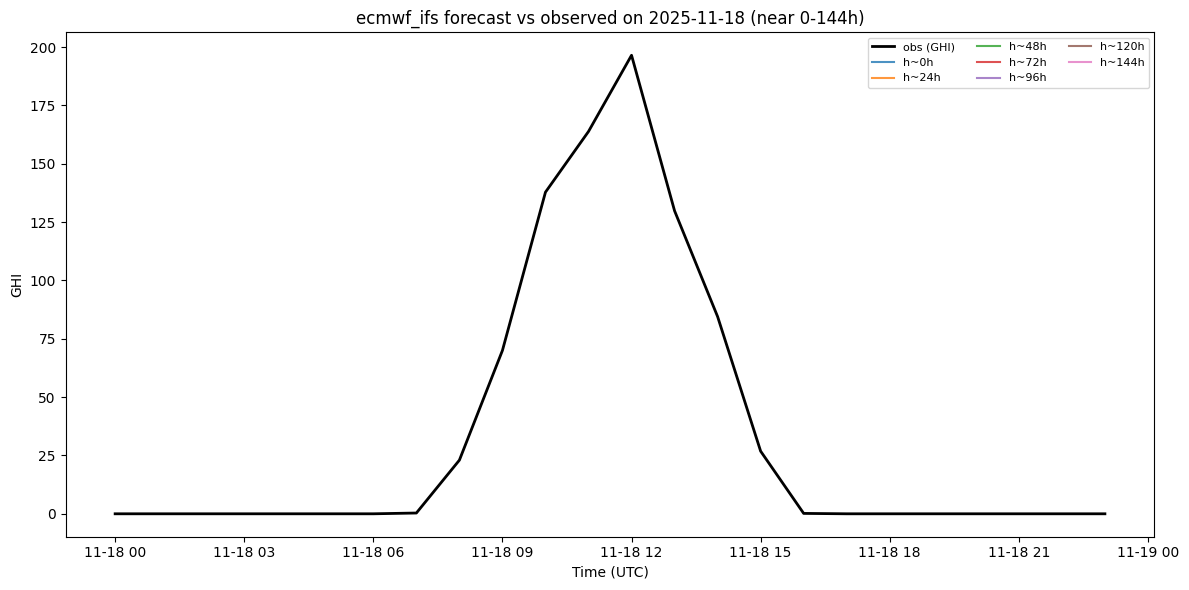

In [32]:

import numpy as np
import pandas as pd

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Focus on one model and one day
model_focus = 'ecmwf_ifs'  # change if you want another
target_day = pd.to_datetime('2025-11-18', utc=True)  # change day if needed

# Available dates for reference
avail_dates = aligned['date'].dt.floor('D').dropna().unique()

fc_day = aligned[(aligned['date'].dt.floor('D') == target_day) & (aligned['model'] == model_focus)].copy()
obs_day = obs_ready[obs_ready['date'].dt.floor('D') == target_day]

if obs_day.empty or fc_day.empty:
    print("Available dates in aligned (UTC):", np.sort(avail_dates))
    raise ValueError("No data for the chosen target_day/model; adjust target_day or model_focus")

fc_day['h_bin'] = fc_day['horizon_hours'].round(0)
fc_day = fc_day[fc_day['h_bin'] <= 168]

available_bins = sorted(fc_day['h_bin'].unique())
print(f"Horizon bins for {model_focus} on {target_day.date()}:", available_bins)

# Plot up to 12 available bins (earliest horizons first)
plot_bins = available_bins[:12]

plt.figure(figsize=(12, 6))
plt.plot(obs_day['date'], obs_day['ghi'], label='obs (GHI)', color='black', linewidth=2)
for hbin in plot_bins:
    grp = fc_day[fc_day['h_bin'] == hbin]
    if grp.empty:
        continue
    plt.plot(grp['date'], grp['forecast'], label=f'h~{int(hbin)}h', alpha=0.8)

plt.xlabel('Time (UTC)')
plt.ylabel('GHI')
plt.title(f'{model_focus} forecast vs observed on {target_day.date()} (earliest horizons)')
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()



## 5) Error metrics by horizon
- Compute RMSE and bias per model per horizon across all files.
- Visualize RMSE(h) and bias(h) curves; highlight best-performing model per horizon.
- Summaries: table of RMSE/Bias for 24h, 48h, 72h, etc.



### Error metrics by horizon
Compute RMSE and bias per model and horizon; plot curves and key horizons (24/48/72h).


Using forecast file: 06072_20251108T0600.csv


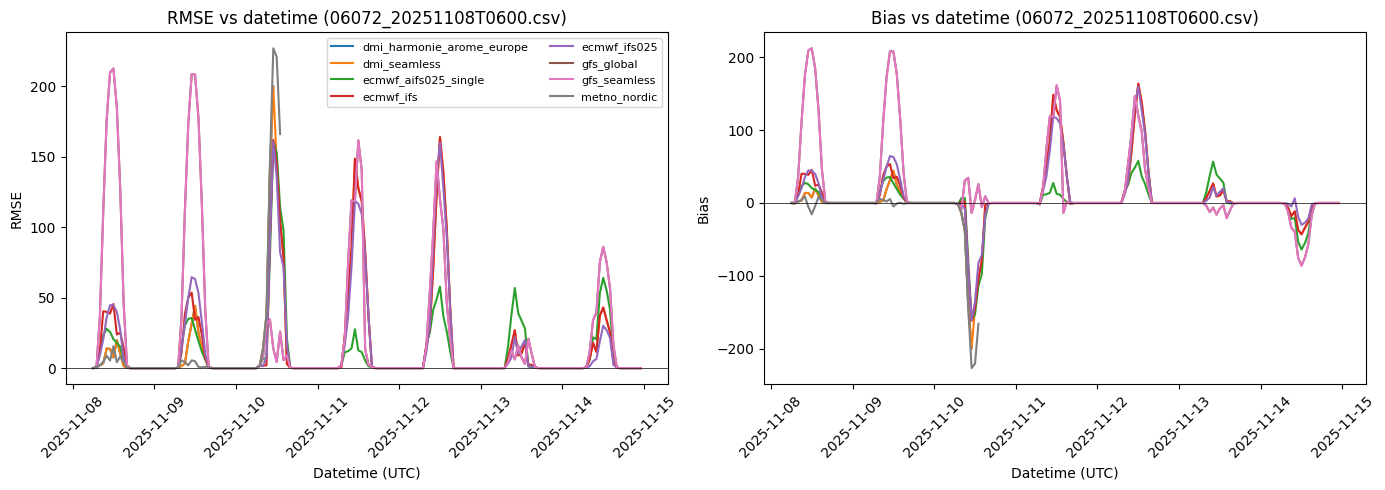

RMSE/Bias at key horizons (rows=model, cols=horizon) for 06072_20251108T0600.csv


rmse           bias          
h_bin                     24.0 48.0 72.0 24.0 48.0 72.0
model                                                  
dmi_harmonie_arome_europe  0.0  0.0  NaN  0.0  0.0  NaN
dmi_seamless               0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_aifs025_single       0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_ifs                  0.0  0.0  0.0  0.0  0.0  0.0
ecmwf_ifs025               0.0  0.0  0.0  0.0  0.0  0.0
gfs_global                 0.0  0.0  0.0  0.0  0.0  0.0
gfs_seamless               0.0  0.0  0.0  0.0  0.0  0.0
metno_nordic               0.0  0.0  NaN  0.0  0.0  NaN

In [21]:

import numpy as np

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Choose which forecast file to analyze (by index in `files`)
selected_idx = 0  # change to another index to pick a different file
if not files:
    raise ValueError("No forecast files loaded in `files`")
selected_file = files[selected_idx].name
print(f"Using forecast file: {selected_file}")

aligned_sel = aligned[aligned['source_file'] == selected_file].copy()
if aligned_sel.empty:
    raise ValueError(f"No aligned rows found for {selected_file}; check selection")

# Compute RMSE and bias per model per timestamp (datetime)
agg = aligned_sel.groupby(['model', 'date']).agg(
    rmse=('error', lambda x: np.sqrt((x**2).mean())),
    bias=('error', 'mean'),
    n=('error', 'size')
).reset_index()

# Plot RMSE and bias vs datetime
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
for model, grp in agg.groupby('model'):
    axes[0].plot(grp['date'], grp['rmse'], label=model)
    axes[1].plot(grp['date'], grp['bias'], label=model)
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('Bias')
for ax in axes:
    ax.set_xlabel('Datetime (UTC)')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.tick_params(axis='x', rotation=45)
axes[0].set_title(f'RMSE vs datetime ({selected_file})')
axes[1].set_title(f'Bias vs datetime ({selected_file})')
axes[0].legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# Summaries at key horizons (keep table for reference)
aligned_sel['h_bin'] = aligned_sel['horizon_hours'].round(0)
key_h = [24, 48, 72]
agg_h = aligned_sel.groupby(['model', 'h_bin']).agg(
    rmse=('error', lambda x: np.sqrt((x**2).mean())),
    bias=('error', 'mean')
).reset_index()
summary = agg_h[agg_h['h_bin'].isin(key_h)].pivot(index='model', columns='h_bin', values=['rmse', 'bias'])
print('RMSE/Bias at key horizons (rows=model, cols=horizon) for', selected_file)
display(summary)



### Average RMSE and bias per model (selected file)


In [22]:

if 'aligned_sel' not in locals():
    raise ValueError("Run the metrics cell above first to set aligned_sel")

avg_metrics = aligned_sel.groupby('model').agg(
    rmse_avg=('error', lambda x: np.sqrt((x**2).mean())),
    bias_avg=('error', 'mean'),
    n=('error', 'size')
).reset_index().sort_values('rmse_avg')

print(f"Average RMSE/Bias for {selected_file} (all horizons)")
display(avg_metrics)


Average RMSE/Bias for 06072_20251108T0600.csv (all horizons)


,model,rmse_avg,bias_avg,n
2,ecmwf_aifs025_single,27.155448,0.065844,162
0,dmi_harmonie_arome_europe,35.014143,-3.268519,54
4,ecmwf_ifs025,37.290052,7.584362,162
3,ecmwf_ifs,39.083753,7.269547,162
1,dmi_seamless,40.133505,4.676955,162
7,metno_nordic,51.890897,-14.252976,56
5,gfs_global,57.347262,18.491770,162
6,gfs_seamless,57.347262,18.491770,162



### Average RMSE and bias per model (all forecast files)


In [23]:

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

avg_all = aligned.groupby('model').agg(
    rmse_avg=('error', lambda x: np.sqrt((x**2).mean())),
    bias_avg=('error', 'mean'),
    n=('error', 'size')
).reset_index().sort_values('rmse_avg')

print("Average RMSE/Bias across all forecast files (all horizons)")
display(avg_all)


Average RMSE/Bias across all forecast files (all horizons)


,model,rmse_avg,bias_avg,n
4,ecmwf_ifs025,23.191329,1.996727,1782
3,ecmwf_ifs,23.866130,3.418724,1782
1,dmi_seamless,25.314954,1.389544,1782
0,dmi_harmonie_arome_europe,26.962515,-3.627104,594
2,ecmwf_aifs025_single,28.957671,-8.236158,1782
7,metno_nordic,30.406688,-5.762175,616
5,gfs_global,35.001614,-2.632903,1782
6,gfs_seamless,35.001614,-2.632903,1782



## 6) Blended forecast attempt
- Try weighted blend (e.g., 80/20 or simple average of top models).
- Optimize weights on a validation slice; compare RMSE/Bias vs best single model.
- Keep method simple and reproducible.



### Blended forecast (top 2 models)
Simple weight search on the two lowest-RMSE models from the selected file.



## 7) Poster-ready figures & notes
- Key plots: forecast vs measurement (one representative day); RMSE/Bias vs horizon.
- Brief bullets on why certain models perform better; note limitations.
- Include method steps, data sources, and time labels (UTC, right-binned).



### Blended forecast across all files
Simple weight search on two models using all aligned data (not just selected file).


In [24]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# --- Config: choose models and weights ---
# Provide exactly two models or leave empty to auto-pick lowest RMSE from avg_all
selected_models_all = ['ecmwf_ifs', 'dmi_harmonie_arome_europe']  # e.g., ['ecmwf_ifs', 'dmi_harmonie_arome_europe']
weight_grid_all = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Optional filters
h_range_all = None          # e.g., (0, 72)
date_range_all = None       # e.g., ('2025-11-09', '2025-11-12')
# ----------------------------------------

work_all = aligned.copy()
if h_range_all:
    hmin, hmax = h_range_all
    work_all = work_all[(work_all['horizon_hours'] >= hmin) & (work_all['horizon_hours'] <= hmax)]
if date_range_all:
    d0 = pd.to_datetime(date_range_all[0])
    d1 = pd.to_datetime(date_range_all[1])
    work_all = work_all[(work_all['date'] >= d0) & (work_all['date'] <= d1)]

if work_all.empty:
    raise ValueError("No data after applying filters; adjust h_range_all/date_range_all")

# choose models
if selected_models_all:
    if len(selected_models_all) != 2:
        raise ValueError("Provide exactly two models in selected_models_all or leave empty")
    top_models_all = selected_models_all
else:
    if 'avg_all' not in locals():
        raise ValueError("Run the overall average metrics cell to populate avg_all")
    top_models_all = avg_all['model'].head(2).tolist()

wide_all = work_all[work_all['model'].isin(top_models_all)].pivot_table(
    index=['date', 'horizon_hours'], columns='model', values='forecast'
)
wide_all = wide_all.dropna()
wide_all = wide_all.join(work_all.set_index(['date', 'horizon_hours'])['ghi']).dropna()

if wide_all.empty:
    raise ValueError("No overlapping data for chosen models/filters; adjust selections")

obs = wide_all['ghi'].values
best = {'w': None, 'rmse': np.inf, 'bias': None}

for w in weight_grid_all:
    blend = w * wide_all[top_models_all[0]] + (1 - w) * wide_all[top_models_all[1]]
    err = blend - obs
    rmse = np.sqrt((err**2).mean())
    bias = err.mean()
    if rmse < best['rmse']:
        best = {'w': w, 'rmse': rmse, 'bias': bias}

blend_label = f"blend {top_models_all[0]}:{best['w']:.2f} / {top_models_all[1]}:{1-best['w']:.2f}"

# compare against best single model overall
best_single_all = avg_all.iloc[0]['model'] if 'avg_all' in locals() else None
rows = [{'model': blend_label, 'rmse': best['rmse'], 'bias': best['bias']}]
if best_single_all:
    single_err_all = work_all[work_all['model'] == best_single_all]['error']
    if not single_err_all.empty:
        rows.append({
            'model': best_single_all,
            'rmse': np.sqrt((single_err_all**2).mean()),
            'bias': single_err_all.mean()
        })

compare_all = pd.DataFrame(rows)
print(f"Using {len(work_all)} points across all files; models: {top_models_all}")
print(f"Blended weight for {top_models_all[0]}: {best['w']:.2f}, {top_models_all[1]}: {1-best['w']:.2f}")
display(compare_all)


Using 11902 points across all files; models: ['ecmwf_ifs', 'dmi_harmonie_arome_europe']
Blended weight for ecmwf_ifs: 0.70, dmi_harmonie_arome_europe: 0.30


,model,rmse,bias
0,blend ecmwf_ifs:0.70 / dmi_harmonie_arome_euro...,21.159860,0.634175
1,ecmwf_ifs025,23.191329,1.996727



### RMSE vs lead time (1-7 days)
Average RMSE/bias per model when truncating horizons to 1-7 days ahead (uses all files; sample size varies by model/day).


In [25]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# baselines over all horizons
baseline = aligned.groupby('model').agg(
    rmse_all=('error', lambda x: np.sqrt((x**2).mean())),
    bias_all=('error', 'mean')
).reset_index()

rows = []
for days in [7,6,5,4,3,2,1]:
    h_max = days * 24
    subset = aligned[aligned['horizon_hours'] <= h_max]
    if subset.empty:
        continue
    agg = subset.groupby('model').agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean'),
        n=('error', 'size')
    ).reset_index()
    agg['days_ahead'] = days
    rows.append(agg)

if not rows:
    raise ValueError("No data for requested day horizons")

results = pd.concat(rows, ignore_index=True)
results = results.merge(baseline, on='model', how='left')
results['rmse_delta'] = results['rmse'] - results['rmse_all']
results['bias_delta'] = results['bias'] - results['bias_all']

# tidy display: smaller days first
results = results.sort_values(['model','days_ahead'], ascending=[True, False])

print("RMSE/Bias by max lead (days), compared to full-horizon baseline (rmse_delta <0 means improvement)")
display(results[['model','days_ahead','rmse','bias','n','rmse_delta','bias_delta']])


RMSE/Bias by max lead (days), compared to full-horizon baseline (rmse_delta <0 means improvement)


,model,days_ahead,rmse,bias,n,rmse_delta,bias_delta
0,dmi_harmonie_arome_europe,7,26.962515,-3.627104,594,0.000000,0.000000
8,dmi_harmonie_arome_europe,6,26.962515,-3.627104,594,0.000000,0.000000
16,dmi_harmonie_arome_europe,5,26.962515,-3.627104,594,0.000000,0.000000
24,dmi_harmonie_arome_europe,4,26.962515,-3.627104,594,0.000000,0.000000
32,dmi_harmonie_arome_europe,3,26.962515,-3.627104,594,0.000000,0.000000
40,dmi_harmonie_arome_europe,2,22.298140,-3.070346,539,-4.664375,0.556758
48,dmi_harmonie_arome_europe,1,22.687159,-2.138788,275,-4.275356,1.488316
1,dmi_seamless,7,25.314954,1.389544,1782,0.000000,0.000000
9,dmi_seamless,6,25.529078,1.223981,1595,0.214124,-0.165562
17,dmi_seamless,5,25.737327,0.605560,1331,0.422372,-0.783984



### Blend comparison by lead time
Grid-search blend of two chosen models across 1-7 day horizons; reports best weight and RMSE/Bias per lead.


In [26]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# --- Config ---
blend_models = ['ecmwf_ifs', 'dmi_seamless']  # e.g., ['ecmwf_ifs', 'dmi_seamless']; leave empty to auto-pick top 2 from avg_all
weight_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lead_days = [7, 6, 5, 4, 3, 2, 1]
# --------------

# choose models
if blend_models:
    if len(blend_models) != 2:
        raise ValueError("Provide exactly two models in blend_models")
    models_use = blend_models
else:
    if 'avg_all' not in locals():
        raise ValueError("Run the overall average metrics cell to populate avg_all")
    models_use = avg_all['model'].head(2).tolist()

rows = []
for days in lead_days:
    h_max = days * 24
    subset = aligned[aligned['horizon_hours'] <= h_max]
    subset = subset[subset['model'].isin(models_use)].copy()
    if subset.empty:
        continue
    wide = subset.pivot_table(index=['date', 'horizon_hours'], columns='model', values='forecast')
    wide = wide.dropna()
    wide = wide.join(subset.set_index(['date', 'horizon_hours'])['ghi']).dropna()
    if wide.empty:
        continue
    obs = wide['ghi'].values
    best = {'w': None, 'rmse': np.inf, 'bias': None}
    for w in weight_grid:
        blend = w * wide[models_use[0]] + (1 - w) * wide[models_use[1]]
        err = blend - obs
        rmse = np.sqrt((err**2).mean())
        bias = err.mean()
        if rmse < best['rmse']:
            best = {'w': w, 'rmse': rmse, 'bias': bias}
    rows.append({
        'days_ahead': days,
        'model': f"blend {models_use[0]}:{best['w']:.2f}/{models_use[1]}:{1-best['w']:.2f}",
        'rmse': best['rmse'],
        'bias': best['bias'],
        'n': len(wide)
    })

if not rows:
    raise ValueError("No data for requested lead days/models")

results = pd.DataFrame(rows).sort_values('days_ahead', ascending=False)
print(f"Blend lead-time results for models: {models_use}")
display(results)


Blend lead-time results for models: ['ecmwf_ifs', 'dmi_seamless']


,days_ahead,model,rmse,bias,n
0,7,blend ecmwf_ifs:0.70/dmi_seamless:0.30,23.404438,2.809970,3564
1,6,blend ecmwf_ifs:0.70/dmi_seamless:0.30,23.403887,2.810940,3190
2,5,blend ecmwf_ifs:0.70/dmi_seamless:0.30,23.190334,2.507288,2662
3,4,blend ecmwf_ifs:0.70/dmi_seamless:0.30,22.373263,1.925133,2134
4,3,blend ecmwf_ifs:0.70/dmi_seamless:0.30,20.606425,0.551308,1606
5,2,blend ecmwf_ifs:0.60/dmi_seamless:0.40,17.269254,0.472882,1078
6,1,blend ecmwf_ifs:0.70/dmi_seamless:0.30,18.336219,0.918303,550



### Day-specific forecast accuracy
Compare RMSE/bias for specific lead days (e.g., day 1 vs day 7) across all forecast files.


In [27]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Configure which lead days to evaluate (1 = 0-24h, 2 = 24-48h, etc.)
target_days = [1, 2, 3, 4, 5, 6, 7]

rows = []
for d in target_days:
    h_low = (d - 1) * 24
    h_high = d * 24
    subset = aligned[(aligned['horizon_hours'] > h_low) & (aligned['horizon_hours'] <= h_high)]
    if subset.empty:
        continue
    agg = subset.groupby('model').agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean'),
        n=('error', 'size')
    ).reset_index()
    agg['day'] = d
    rows.append(agg)

if not rows:
    raise ValueError("No data for selected target_days")

results = pd.concat(rows, ignore_index=True)
results = results.sort_values(['day', 'rmse'])
print("RMSE/Bias by specific lead day (across all files; day 1 = 0-24h, day 7 = 144-168h)")
display(results[['day', 'model', 'rmse', 'bias', 'n']])


RMSE/Bias by specific lead day (across all files; day 1 = 0-24h, day 7 = 144-168h)


,day,model,rmse,bias,n
3,1,ecmwf_ifs,19.713651,2.321338,264
4,1,ecmwf_ifs025,21.192880,1.631944,264
7,1,metno_nordic,22.640148,-4.534722,264
0,1,dmi_harmonie_arome_europe,23.154984,-2.227904,264
1,1,dmi_seamless,23.154984,-2.227904,264
2,1,ecmwf_aifs025_single,26.993977,-6.080177,264
5,1,gfs_global,38.708628,-1.307449,264
6,1,gfs_seamless,38.708628,-1.307449,264
11,2,ecmwf_ifs,19.351035,3.466856,264
12,2,ecmwf_ifs025,19.742722,3.322917,264



### Day-specific RMSE/Bias plot
Visualize RMSE and Bias by day horizon (day 1 = 0-24h, ..., day 7 = 144-168h).


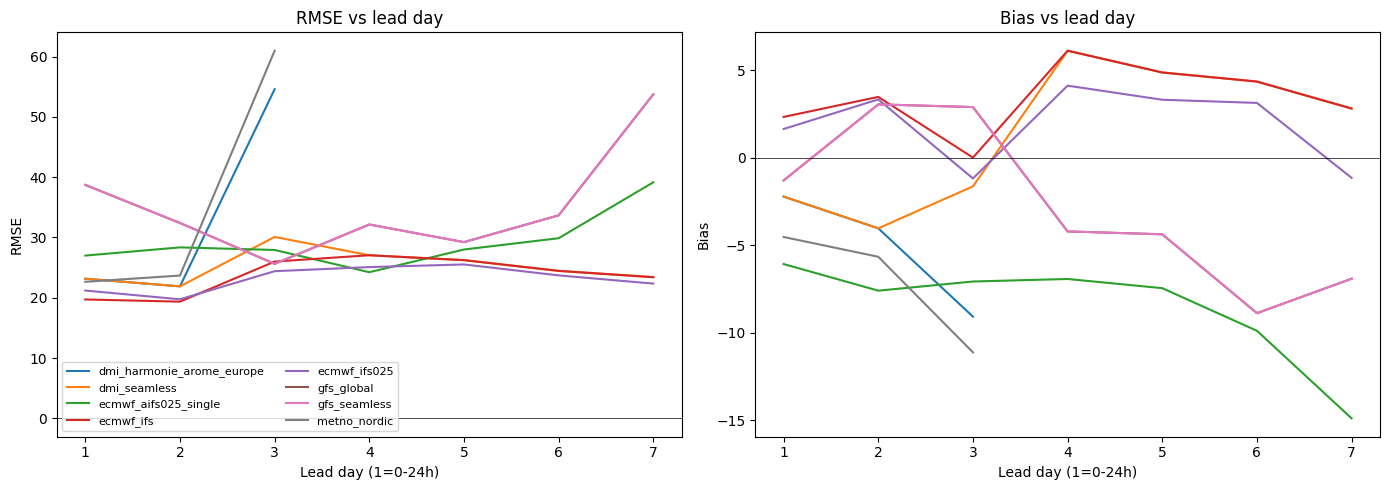

In [28]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# same config as table
plot_days = [1, 2, 3, 4, 5, 6, 7]

rows = []
for d in plot_days:
    h_low = (d - 1) * 24
    h_high = d * 24
    subset = aligned[(aligned['horizon_hours'] > h_low) & (aligned['horizon_hours'] <= h_high)]
    if subset.empty:
        continue
    agg = subset.groupby('model').agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean')
    ).reset_index()
    agg['day'] = d
    rows.append(agg)

if not rows:
    raise ValueError("No data for selected plot_days")

results = pd.concat(rows, ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
for model, grp in results.groupby('model'):
    axes[0].plot(grp['day'], grp['rmse'], label=model)
    axes[1].plot(grp['day'], grp['bias'], label=model)
axes[0].set_xlabel('Lead day (1=0-24h)')
axes[1].set_xlabel('Lead day (1=0-24h)')
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('Bias')
for ax in axes:
    ax.axhline(0, color='k', linewidth=0.5)
axes[0].set_title('RMSE vs lead day')
axes[1].set_title('Bias vs lead day')
axes[0].legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()
